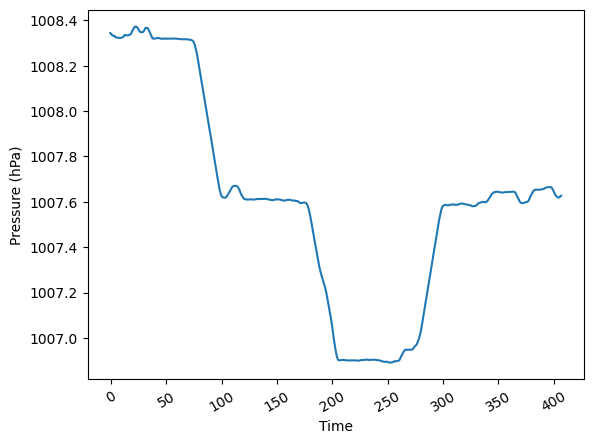

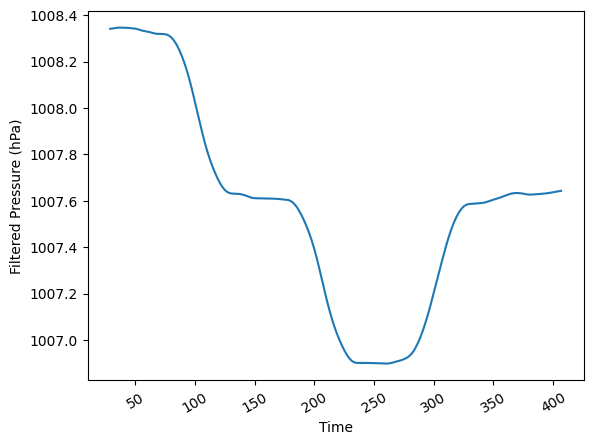

In [18]:
"""
This program initializes several parameters including the time period for calculation in seconds, the number of data points to use for slope calculation, and the minimum slope required to trigger a floor level change.

The barometer readings are loaded from a file or sensor and the program loops through the data points within the time period. Within each loop, the slope of the previous SLOPE_PERIOD data points is calculated using numpy's polyfitfunction. If the slope is below the threshold, it is assumed that the reading is stable. If the reading is significantly different from the latest stable reading, the floor level is assumed to have changed. If the reading is higher, the person is assumed to have gone up a floor, and if the reading is lower, the person is assumed to have gone down a floor. The latest stable reading is then set to the current reading, and the new floor level is printed.

If the slope is above the threshold, it is assumed that the reading is still changing, and the latest stable reading is reset to the current reading.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Set the number of data points to use for slope calculation
SLOPE_PERIOD = 20

# Set the minimum slope required to trigger a floor level change
SLOPE_THRESHOLD = 0.008

# Load the barometer readings from a file or sensor
df = pd.read_csv('Raw Data.csv')

# Set the index of the dataframe as the time column
df = df.set_index('Time (s)')

# Plot time series graph of the pressure data
plt.plot(df.index, df['Pressure (hPa)'])
plt.xlabel('Time')
plt.ylabel('Pressure (hPa)')
plt.xticks(rotation=30)
plt.show()

# Set the size of the moving average window
window_size = 30

# Apply the moving average filter to the 'Pressure (hPa)' column
df['pressure_filtered'] = df['Pressure (hPa)'].rolling(window_size).mean()

# Plot time series graph of the pressure data
plt.plot(df.index, df['pressure_filtered'])
plt.xlabel('Time')
plt.ylabel('Filtered Pressure (hPa)')
plt.xticks(rotation=30)
plt.show()

barometer_readings = df['pressure_filtered'].values

for i in range(barometer_readings.size):
    if (math.isnan(barometer_readings[i])):
        barometer_readings[i] = (df['Pressure (hPa)'].values)[i]


In [30]:
# Calculate the number of data points in the time period
num_points = df.index.size

# Set the number of data points to use for slope calculation
SLOPE_PERIOD = 15

REQ_DIFF = 0.1

# Initialize the floor level and latest stable reading
floor_level = 0
latest_stable_reading = barometer_readings[0]

# Loop through the data points in the time period
for i in range(len(barometer_readings)-SLOPE_PERIOD):

    # Calculate the slope of the previous SLOPE_PERIOD data points
    slope = np.polyfit(range(SLOPE_PERIOD), barometer_readings[i:i+SLOPE_PERIOD], 1)[0]
    
    # If the slope is below the threshold, assume it's stable
    if abs(slope) < SLOPE_THRESHOLD:

        # print("T/F: ", abs(barometer_readings[i] - latest_stable_reading) > REQ_DIFF)
        # print("abs(barometer_readings[", i, "] - latest_stable_reading) = ", abs(barometer_readings[i] - latest_stable_reading))

        # If the reading is significantly different from the latest stable reading, assume the floor level changed
        if abs(barometer_readings[i] - latest_stable_reading) > REQ_DIFF:

            # print("Status at t = ", df.index[i], "s, ", "stable slope (on same level), but significant change in reading")

            # If the reading is higher, assume the person went down a floor
            if barometer_readings[i] > latest_stable_reading:            
                floor_level -= 1

                # Set the latest stable reading to the current reading
                latest_stable_reading = barometer_readings[i]

                # Print the new floor level
                print("Person arrived on floor ", floor_level, " at t = ", df.index[i], "s", sep="")

            # If the reading is lower, assume the person went up a floor
            elif barometer_readings[i] < latest_stable_reading:
                floor_level += 1

                # Set the latest stable reading to the current reading
                latest_stable_reading = barometer_readings[i]

                # Print the new floor level
                print("Person arrived on floor ", floor_level, " at t = ", df.index[i], "s", sep="")

        else:
            # latest_stable_reading remains unchanged because
            # the slope is stable, on same level: abs(slope) < SLOPE_THRESHOLD
            # reading is approximately same with the previous latest stable reading: abs(barometer_readings[i] - latest_stable_reading) < REQ_DIFF"

            # print("Status at t = ", df.index[i], "s, ", "stable slope (on same level), and stable reading, no change in latest_stable_reading")
            pass

    # If the slope is above the threshold, assume the reading is still changing
    else:

        # Reset the latest stable reading to the current reading
        # latest_stable_reading CHANGED because
        # the slope is high, moving to another level: abs(slope) > SLOPE_THRESHOLD

        latest_stable_reading = barometer_readings[i]

        # print("Status at t = ", df.index[i], "s, ", "high slope (moving to another level), latest_stable_reading changed to current reading")
        # print("slope = ", slope)

Person arrived on floor 1 at t = 125.691118s
Person arrived on floor 2 at t = 231.708872s
Person arrived on floor 1 at t = 325.001663s


**Remarks:**

1st part of the program:

Filter the collected data. If we take the device in our hands we may cause fluctuations in the barometer reading. To eliminate these effects and ensure that the change in air pressure is purely caused by change in floor level, we filter out these noises and use the filtered air pressure data for analysis.

2nd part of the program:

We take i to i + SLOPE_PERIOD barometer reading to calculate the slope. If the absolute value of the slope is higher than the SLOPE_THRESHOLD, it is considered that the user is moving from a level to another.

The latest stable reading is recorded as a reference to check if the user transitted to another level. This indicator will change under three circumstances:

(i) The person just went up a floor 
(ii) The person just went down a floor 
(iii) The person is during the process of moving to another floor (i.e. on an escalator) or putting down their device 

We can see that the latest stable reading is not changed when the person is on the floor (i.e. the air pressure of the device is generally the same with the previously-obtained data)

If the absolute value of the barometer reading is significantly different from the latest stable reading, it is considered that the floor level has been changed. It is to ensure that the difference in air pressure is large enough so that we can eliminate the effect of putting down a phone on the same floor.
